In [33]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import os 

# For Data PreProcessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.utils import to_categorical
from random import randint, choice

# Old DBN Class
# from dbn.tensorflow import SupervisedDBNClassification

# Models used
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import GridSearchCV

In [36]:
csv_filename = "qc aggregated data.csv"
df = pd.read_csv(csv_filename)
df["description"].unique(), len(df["description"].unique())

(array(['Partly cloudy throughout the day.',
        'Partly cloudy throughout the day with late afternoon rain.',
        'Partly cloudy throughout the day with early morning rain.',
        'Partly cloudy throughout the day with afternoon rain.',
        'Partly cloudy throughout the day with rain.',
        'Cloudy skies throughout the day with rain clearing later.',
        'Partly cloudy throughout the day with morning rain.',
        'Partly cloudy throughout the day with rain clearing later.',
        'Partly cloudy throughout the day with rain in the morning and afternoon.',
        'Cloudy skies throughout the day with a chance of rain throughout the day.',
        'Cloudy skies throughout the day with afternoon rain.',
        'Becoming cloudy in the afternoon.',
        'Partly cloudy throughout the day with a chance of rain throughout the day.',
        'Clearing in the afternoon.',
        'Cloudy skies throughout the day with early morning rain.',
        'Cloudy skies th

In [21]:
# Get Data from File
csv_filename = "qc aggregated data.csv"
df = pd.read_csv(csv_filename)

# Specify Input and Output from Data
# input_columns = ["tempmax", "tempmin", "temp", "feelslikemax", "feelslikemin", "feelslike", "dew", "humidity", "windspeed"]
input_columns = ["temp", "feelslike", "dew", "humidity", "windspeed"]
output_column = ["conditions"]

weather_conditions = {
"Overcast" : "Sunny", 
"Partially cloudy" : "Cloudy", 
"Rain, Overcast" : "Rainy",
"Rain, Partially cloudy" : "Stormy"
}
df["conditions"] = df["conditions"].replace(weather_conditions)

df = df[input_columns + output_column]
df.conditions = df.conditions.shift(-1)
df.dropna(inplace=True)

In [22]:
X = df[input_columns].to_numpy()
Y = df[output_column].to_numpy()
X = X.astype(float)
X = X - X.min()
X = X / X.max()

le = LabelEncoder()
Y = le.fit_transform(Y)

c:\Users\Alaric\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
win_length = 5
new_X = []
new_Y = []
for row in range(win_length, len(X)):
    t_l = list(X[row])
    for prev_row in range(row-1, row-win_length-1, -1):
        t_l.extend(list(X[prev_row]))
    new_X.append(t_l)

    new_Y.append(Y[row])

new_X = np.array(new_X)
new_Y = np.array(new_Y)
X = new_X 
Y = new_Y

In [24]:
conditions, counts = np.unique(Y, return_counts=True)
target_num = max(counts)

new_X = []
new_Y = []

for condition in conditions:
    #print(condition)
    available_roster = np.where(Y == condition)
    available_roster = available_roster[0]

    t_l_x = []
    t_l_y = []


    for roster in available_roster:
        t_l_x.append(X[roster].tolist())
        t_l_y.append(Y[roster])
    
    #print(np.array(t_l_x))
    #break 

    target_clocks = target_num - len(t_l_x)

    for rem in range(target_clocks):
        r_i = choice(available_roster)
        #print("Choice: " ,r_i, " Roster: ", available_roster)
        t_l_x.append(X[r_i].tolist())
        t_l_y.append(Y[r_i])
    
    print(np.array(t_l_x).shape, target_num)

    new_X.extend(t_l_x)
    new_Y.extend(t_l_y)

new_X = np.array(new_X)
new_Y = np.array(new_Y)
X = new_X
Y = new_Y
    



(1213, 30) 1213
(1213, 30) 1213
(1213, 30) 1213
(1213, 30) 1213


In [25]:
new_X.shape, target_num * 4, new_Y.shape, new_Y[4852-1214]

((4852, 30), 4852, (4852,), 2)

In [26]:
X[0], Y[0]

(array([0.16618076, 0.18731778, 0.14285714, 0.57507289, 0.09693878,
        0.16326531, 0.17930029, 0.13483965, 0.54883382, 0.04446064,
        0.17201166, 0.19023324, 0.12463557, 0.46574344, 0.1122449 ,
        0.16836735, 0.18731778, 0.13702624, 0.53862974, 0.12390671,
        0.16180758, 0.17492711, 0.12973761, 0.53134111, 0.1377551 ,
        0.15816327, 0.16472303, 0.11588921, 0.48177843, 0.13848397]),
 0)

In [27]:
# Preprocess the data (Convert raw string conditions to numerical values, and split data)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
while (len(np.unique(Y_train)) != len(le.classes_)) or (len(np.unique(Y_test)) != len(le.classes_)):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Class mapping - used later for labelling
label_mapping = {x: y for x, y in zip(le.transform(le.classes_), le.classes_)}
lm = list(label_mapping.values())
lm = [x.replace(",", ",\n") for x in lm]

In [28]:
lm

['Cloudy', 'Rainy', 'Stormy', 'Sunny']

[BernoulliRBM] Iteration 1, pseudo-likelihood = -16.51, time = 0.06s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -14.46, time = 0.14s


[BernoulliRBM] Iteration 3, pseudo-likelihood = -13.23, time = 0.13s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -12.65, time = 0.11s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -11.82, time = 0.12s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -11.50, time = 0.17s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -11.30, time = 0.12s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -11.08, time = 0.11s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -11.02, time = 0.13s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -10.83, time = 0.14s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -44.16, time = 0.11s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -44.05, time = 0.21s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -43.98, time = 0.14s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -43.93, time = 0.14s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -43.90, time = 0.12s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -43.89, time = 0.15s
[BernoulliRBM] Iteration 7, pseud

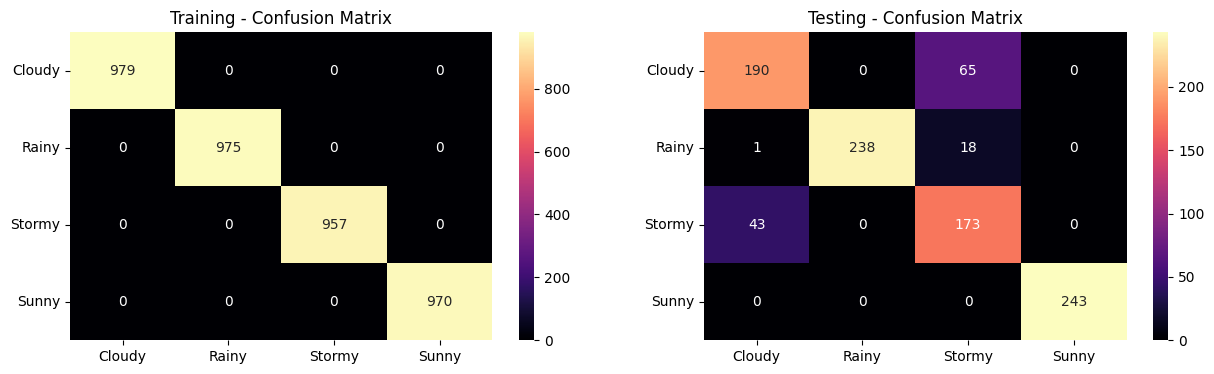

Testing: 0.8692070030895983 
Training: 1.0


In [29]:
learning_rate = 0.001
total_units = 64
total_epochs = 10
batch_size = 32

# RBM
rbm = BernoulliRBM(n_components=total_units, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=1)

# Random Forest
r_forest = RandomForestClassifier(verbose=0)

# Decision Tree
d_tree = DecisionTreeClassifier()

# SVC
s_v_c = SVC()

# Gaussian
gpc = GaussianProcessClassifier()

# K Neighbors
kneighhclassif = KNeighborsClassifier()


# ('rbm1', clone(rbm)),
model = Pipeline(steps=[
    ('rbm1', clone(rbm)),
    ('rbm2', clone(rbm)),
    ('rfc', clone(r_forest))
    ])
model.fit(X_train, Y_train)

# Predict on training (for verification)
Y_pred_train = model.predict(X_train)
CM_train = confusion_matrix(Y_pred_train, Y_train)
train_acc = accuracy_score(Y_train, Y_pred_train)

# Testing Plot
plt.figure(figsize=(15, 4))
ax = plt.subplot(121)
ax.set_title("Training - Confusion Matrix")
sns.heatmap(CM_train, annot=True, cmap="magma", ax=ax, fmt='d')
ax.xaxis.set_ticklabels(lm)
ax.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

# Predict on testing (for verification)
Y_pred_test = model.predict(X_test)
CM_test = confusion_matrix(Y_pred_test, Y_test)
test_acc = accuracy_score(Y_test, Y_pred_test)

ax2 = plt.subplot(122)
ax2.set_title("Testing - Confusion Matrix")
sns.heatmap(CM_test, annot=True, cmap="magma", ax=ax2, fmt='d')
ax2.xaxis.set_ticklabels(lm)
ax2.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

plt.show()
print(f"Testing: {test_acc} \nTraining: {train_acc}")

[BernoulliRBM] Iteration 1, pseudo-likelihood = -16.58, time = 0.10s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -14.53, time = 0.13s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -13.31, time = 0.11s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -12.52, time = 0.14s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -12.06, time = 0.15s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -11.60, time = 0.15s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -11.42, time = 0.12s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -11.09, time = 0.15s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -10.95, time = 0.16s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -10.86, time = 0.15s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -44.16, time = 0.13s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -44.05, time = 0.18s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -43.99, time = 0.16s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -43.94, time = 0.14s
[BernoulliRBM] Iteration 5, pseud

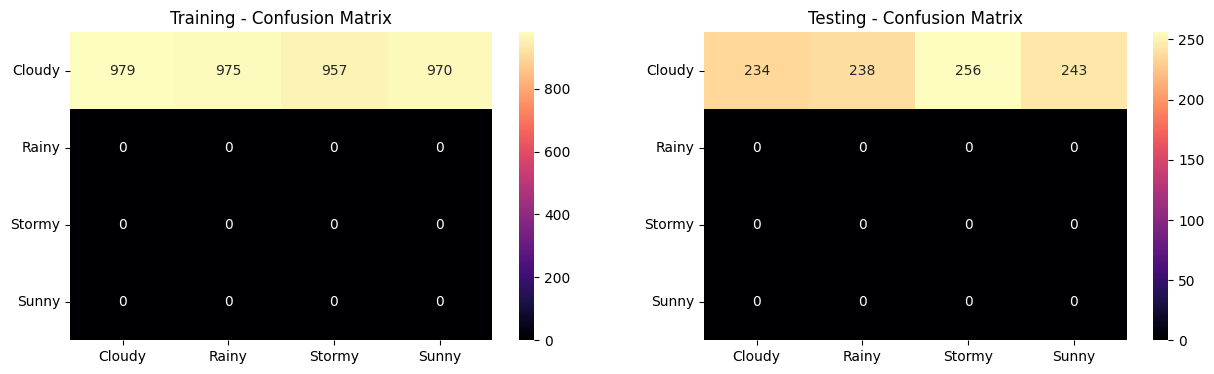

Testing: 0.24098867147270855 
Training: 0.25225457356351455


In [30]:
model = Pipeline(steps=[
    ('rbm1', clone(rbm)),
    ('rbm2', clone(rbm)),
    ('rbm3', clone(rbm)),
    ('rbm4', clone(rbm)),
    ('rbm5', clone(rbm)),
    ('rbm6', clone(rbm)),
    ('rbm7', clone(rbm)),
    ('rbm8', clone(rbm)),
    ('rbm9', clone(rbm)),
    ('rbm10', clone(rbm)),
    ('rfc', clone(r_forest))
    ])
model.fit(X_train, Y_train)

# Predict on training (for verification)
Y_pred_train = model.predict(X_train)
CM_train = confusion_matrix(Y_pred_train, Y_train)
train_acc = accuracy_score(Y_train, Y_pred_train)

# Testing Plot
plt.figure(figsize=(15, 4))
ax = plt.subplot(121)
ax.set_title("Training - Confusion Matrix")
sns.heatmap(CM_train, annot=True, cmap="magma", ax=ax, fmt='d')
ax.xaxis.set_ticklabels(lm)
ax.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

# Predict on testing (for verification)
Y_pred_test = model.predict(X_test)
CM_test = confusion_matrix(Y_pred_test, Y_test)
test_acc = accuracy_score(Y_test, Y_pred_test)

ax2 = plt.subplot(122)
ax2.set_title("Testing - Confusion Matrix")
sns.heatmap(CM_test, annot=True, cmap="magma", ax=ax2, fmt='d')
ax2.xaxis.set_ticklabels(lm)
ax2.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

plt.show()
print(f"Testing: {test_acc} \nTraining: {train_acc}")

[BernoulliRBM] Iteration 1, pseudo-likelihood = -16.53, time = 0.08s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -14.48, time = 0.11s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -13.29, time = 0.13s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -12.53, time = 0.14s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -12.07, time = 0.13s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -11.62, time = 0.16s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -11.40, time = 0.15s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -11.09, time = 0.12s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -10.74, time = 0.15s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -10.74, time = 0.16s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -44.16, time = 0.14s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -44.04, time = 0.15s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -43.97, time = 0.17s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -43.93, time = 0.14s
[BernoulliRBM] Iteration 5, pseud

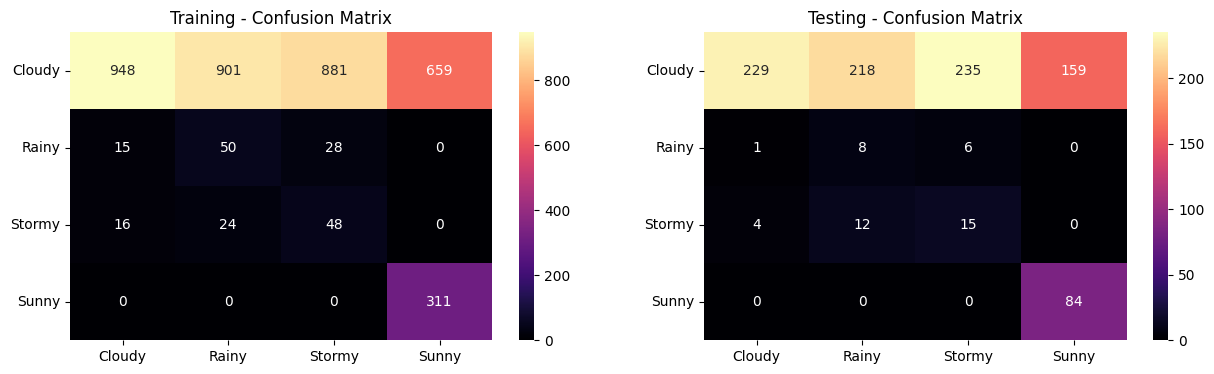

Testing: 0.34603501544799176 
Training: 0.34965215150734347


In [31]:
model = Pipeline(steps=[
    ('rbm1', clone(rbm)),
    ('rbm2', clone(rbm)),
    ('rbm3', clone(rbm)),
    ('rbm4', clone(rbm)),
    ('rbm5', clone(rbm)),
    ('rfc', clone(r_forest))
    ])
model.fit(X_train, Y_train)

# Predict on training (for verification)
Y_pred_train = model.predict(X_train)
CM_train = confusion_matrix(Y_pred_train, Y_train)
train_acc = accuracy_score(Y_train, Y_pred_train)

# Testing Plot
plt.figure(figsize=(15, 4))
ax = plt.subplot(121)
ax.set_title("Training - Confusion Matrix")
sns.heatmap(CM_train, annot=True, cmap="magma", ax=ax, fmt='d')
ax.xaxis.set_ticklabels(lm)
ax.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

# Predict on testing (for verification)
Y_pred_test = model.predict(X_test)
CM_test = confusion_matrix(Y_pred_test, Y_test)
test_acc = accuracy_score(Y_test, Y_pred_test)

ax2 = plt.subplot(122)
ax2.set_title("Testing - Confusion Matrix")
sns.heatmap(CM_test, annot=True, cmap="magma", ax=ax2, fmt='d')
ax2.xaxis.set_ticklabels(lm)
ax2.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

plt.show()
print(f"Testing: {test_acc} \nTraining: {train_acc}")

[BernoulliRBM] Iteration 1, pseudo-likelihood = -16.60, time = 0.13s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -14.57, time = 0.24s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -13.31, time = 0.14s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -12.52, time = 0.14s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -11.91, time = 0.11s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -11.38, time = 0.11s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -11.29, time = 0.11s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -10.98, time = 0.10s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -10.86, time = 0.10s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -10.90, time = 0.13s
[BernoulliRBM] Iteration 1, pseudo-likelihood = -44.17, time = 0.11s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -44.06, time = 0.15s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -43.99, time = 0.12s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -43.95, time = 0.12s
[BernoulliRBM] Iteration 5, pseud

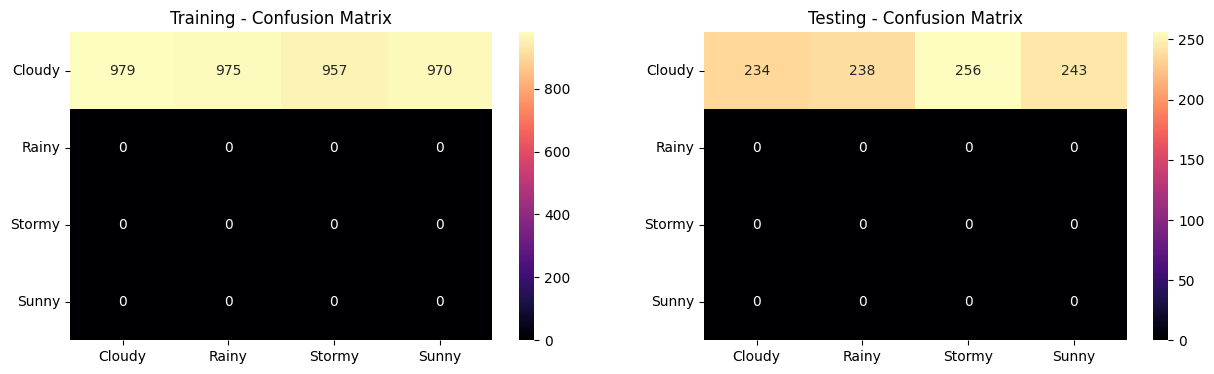

Testing: 0.24098867147270855 
Training: 0.25225457356351455


In [32]:
model = Pipeline(steps=[])

for x in range(100):
    model.steps.append((f'rbm{x}', clone(rbm)))

model.steps.append(('rfc', clone(r_forest))) 

model.fit(X_train, Y_train)

# Predict on training (for verification)
Y_pred_train = model.predict(X_train)
CM_train = confusion_matrix(Y_pred_train, Y_train)
train_acc = accuracy_score(Y_train, Y_pred_train)

# Testing Plot
plt.figure(figsize=(15, 4))
ax = plt.subplot(121)
ax.set_title("Training - Confusion Matrix")
sns.heatmap(CM_train, annot=True, cmap="magma", ax=ax, fmt='d')
ax.xaxis.set_ticklabels(lm)
ax.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

# Predict on testing (for verification)
Y_pred_test = model.predict(X_test)
CM_test = confusion_matrix(Y_pred_test, Y_test)
test_acc = accuracy_score(Y_test, Y_pred_test)

ax2 = plt.subplot(122)
ax2.set_title("Testing - Confusion Matrix")
sns.heatmap(CM_test, annot=True, cmap="magma", ax=ax2, fmt='d')
ax2.xaxis.set_ticklabels(lm)
ax2.yaxis.set_ticklabels(lm)
plt.yticks(rotation=0)

plt.show()
print(f"Testing: {test_acc} \nTraining: {train_acc}")